# Imports

In [11]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 120

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

# make parent kaggle folder importable
import sys
import os
sys.path.append(os.path.abspath("../"))

import importlib
import graphs as g
import utils as u
import processing as p
import model as m

# Data

In [155]:
train_data = pd.read_json('input/train.json')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [156]:
test_data = pd.read_json('input/test.json')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 14 columns):
bathrooms          74659 non-null float64
bedrooms           74659 non-null int64
building_id        74659 non-null object
created            74659 non-null object
description        74659 non-null object
display_address    74659 non-null object
features           74659 non-null object
latitude           74659 non-null float64
listing_id         74659 non-null int64
longitude          74659 non-null float64
manager_id         74659 non-null object
photos             74659 non-null object
price              74659 non-null int64
street_address     74659 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB


In [157]:
importlib.reload(p)

managers = train_data.manager_id.append(test_data.manager_id).values
manager_le = p.label_encoder(managers, 'managers')

buildings = train_data.building_id.append(test_data.building_id).values
building_le = p.label_encoder(buildings, 'buildings')

addresses = train_data.display_address.append(test_data.display_address).values
address_le = p.label_encoder(addresses, 'addresses')

managers: 4399 
buildings: 11635 
addresses: 16068 


In [158]:
from datetime import datetime
import re

def feature(text):
    if '*' in text:
        return ''
    else:
        text = list(filter(lambda t: len(t) < 11, text))
        return ','.join(text).lower()

# train
# train_data['created'] = train_data['created'].map(lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M:%S').month)
train_data['manager_id'] = manager_le.transform(train_data.manager_id)
train_data['building_id'] = building_le.transform(train_data.building_id)
train_data['display_address'] = address_le.transform(train_data.display_address)
train_data['features'] = train_data.features.map(lambda f: feature(f))
train_data['interest_level'].replace(['low', 'medium', 'high'], [0, 1, 2], inplace=True)

# test
test_data['manager_id'] = manager_le.transform(test_data.manager_id)
test_data['building_id'] = building_le.transform(test_data.building_id)
test_data['display_address'] = address_le.transform(test_data.display_address)
test_data['features'] = test_data.features.map(lambda f: feature(f))

In [125]:
train_data.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,3797,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,12282,,1,40.7145,7211212,-73.9425,1568,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,8986,2016-06-12 12:19:27,,9080,"doorman,elevator",0,40.7947,7150865,-73.9667,1988,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,8889,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",13719,dishwasher,2,40.7388,6887163,-74.0018,3733,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,1848,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,10866,no fee,0,40.7539,6888711,-73.9677,282,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,15072,pre-war,0,40.8241,6934781,-73.9493,2618,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


# Feature extraction

In [159]:
features = train_data.features.str.get_dummies(',')
# features.columns[100:400]

features.shape
# train_data.features[100:200]

(49352, 210)

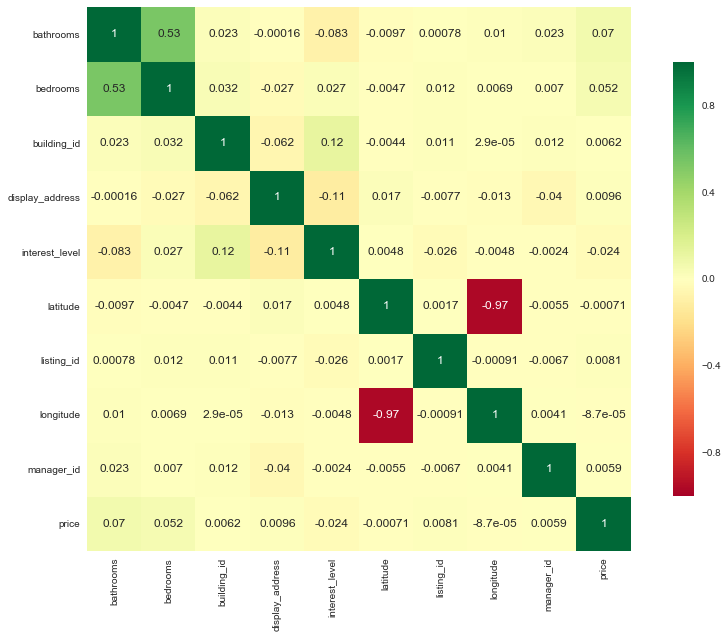

In [135]:
importlib.reload(g)

g.plot_correlation_map(train_data)

# Feature selection

In [147]:
features_columns = ['bathrooms', 'bedrooms', 'building_id', 'display_address', 'manager_id', 'price']
labels_columns = ['interest_level']

In [178]:
importlib.reload(p)
from sklearn import preprocessing

x = train_data[features_columns]
# x = pd.merge(x, features, right_index=True, left_index=True)
x = x.fillna(0)

y = train_data[labels_columns]

X = p.scale(x)
Y = p.onehot(y)


X: (49352, 6) 
Y: (49352, 3) 


In [176]:
features.columns

Index(['1.5 bath', '1.5 baths', '1/2 bath', '1100 sq ft', '1200sq ft', '1st',
       '2', '22', '2nd ave', '3',
       ...
       'walk up', 'walk-up', 'walls ok', 'wash/dryer', 'washer', 'water view',
       'wifi', 'yard', 'yoga room', ' subway'],
      dtype='object', length=210)

# Model

Train on 44416 samples, validate on 4936 samples
Epoch 1/10
44416/44416 [==============================] - 3s - loss: 0.7910 - acc: 0.6937 - val_loss: 0.7820 - val_acc: 0.6896

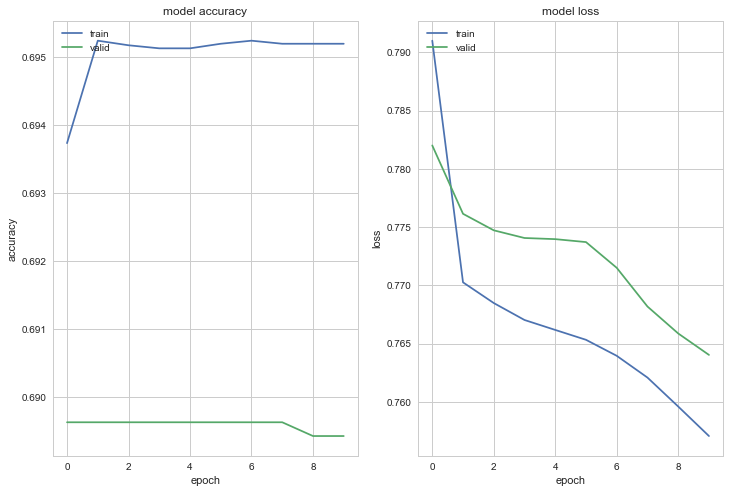

In [183]:
importlib.reload(m)
importlib.reload(g)
from keras import optimizers

model = m.keras_classification(X.shape[1], Y.shape[1])
o = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=o, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.1, epochs=10)
model.save('rental.h5')

plt.figure(figsize=(12,8))
g.plot_accuracy(history)
g.plot_loss(history)

In [185]:
importlib.reload(m)
importlib.reload(g)

model = m.tflearn_classification(X.shape[1], Y.shape[1])
model.fit(X, Y, validation_set=0.1, show_metric=True)


Training Step: 3779  | total loss: 0.77604 | time: 1.054s
| RMSProp | epoch: 006 | loss: 0.77604 - acc: 0.6920 -- iter: 19776/44416


KeyboardInterrupt: 

# Prediction


In [63]:
importlib.reload(pp)
from sklearn import preprocessing

xx = test_data[features]
XX = preprocessing.scale(xx.values)
print(XX.shape)

print(x.head())
print()
print(X[:3])

(74659, 6)
        bathrooms  bedrooms  building_id  display_address  manager_id  price
10            1.5         3         3797            12282        1568   3000
10000         1.0         2         8986             9080        1988   5465
100004        1.0         1         8889            13719        3733   2850
100007        1.0         1         1848            10866         282   3275
100013        1.0         4            0            15072        2618   3350

[[ 0.57401637  1.30793808 -0.31105435  0.35386594 -0.53413236 -0.03762122]
 [-0.42316255  0.41108287  1.07763425 -0.54239809 -0.20354278  0.07408585]
 [-0.42316255 -0.48577234  1.05167495  0.75609312  1.16997823 -0.04441881]]


In [65]:
YY = model.predict(XX)
print(YY.shape)
print(YY[:10])

(74659, 3)
[[  5.05263507e-01   3.48529935e-01   1.46206558e-01]
 [  5.79756737e-01   2.97308296e-01   1.22934960e-01]
 [  8.48216891e-01   1.19578689e-01   3.22043821e-02]
 [  4.11432803e-01   3.48462164e-01   2.40105093e-01]
 [  9.32651699e-01   6.29571229e-02   4.39117430e-03]
 [  9.99370754e-01   6.28602924e-04   7.61146509e-07]
 [  2.29961798e-01   4.02387679e-01   3.67650509e-01]
 [  3.37359965e-01   3.76057953e-01   2.86582112e-01]
 [  3.89883339e-01   4.13357675e-01   1.96758926e-01]
 [  2.28537098e-01   4.08260792e-01   3.63202125e-01]]


# Submission

In [66]:
import time
sample = pd.read_csv('input/sample_submission.csv')
print(sample.shape)

submission = pd.DataFrame(columns=['listing_id', 'high', 'medium', 'low'])
submission.listing_id = sample.listing_id
submission.low = YY[:,0]
submission.medium = YY[:,1]
submission.high = YY[:,2]
submission.info()

filename = 'submission-' + time.strftime("%Y%m%d%H%M", time.gmtime()) + '.csv'
submission.to_csv(filename, index=False)

(74659, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74659 entries, 0 to 74658
Data columns (total 4 columns):
listing_id    74659 non-null int64
high          74659 non-null float32
medium        74659 non-null float32
low           74659 non-null float32
dtypes: float32(3), int64(1)
memory usage: 1.4 MB


# References

* https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/do-managers-matter-some-insights-on-manager-id/
* https://www.kaggle.com/den3b81/two-sigma-connect-rental-listing-inquiries/some-insights-on-building-id
* https://www.kaggle.com/guoday/two-sigma-connect-rental-listing-inquiries/cv-statistics-better-parameters-and-explaination/notebook